In [1]:
import numpy as np
np.set_printoptions(suppress=True)

import networkx as nx
from sklearn.neighbors import KDTree

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10, 10)

from udacity_stuff import extract_polygons, load_data

In [2]:
def sample_points(data, polygons, n_points=100, z_limit=10):
    centers = data[:, 0:3]
    sizes = data[:, 3:6]
    
    #radius_xyz = np.sqrt(np.sum(sizes**2, axis=1)).max()
    radius_xy = np.sqrt(np.sum(sizes[:,0:2]**2, axis=1)).max()

    max_x, max_y, max_z = np.max(centers + sizes, axis=0)
    min_x, min_y, min_z = np.min(centers - sizes, axis=0)

    # sample n_points
    points = np.random.uniform(low=[min_x, min_y, min_z],
                             high=[max_x, max_y, min(max_z, z_limit)],
                             size=(n_points,3))

    tree = KDTree(centers[:,0:2], metric='euclidean')

    good_points = []
    for p in points:
        bad = False
        for n_idx in tree.query_radius([[p[0], p[1]]], r=radius_xy)[0]:
            if polygons[n_idx].contains(p):
                bad = True
                break
        if not bad:
            good_points.append(p)
            
    return np.array(good_points)

# Sampling collision-free points

In [4]:
data = load_data('colliders.csv')
obstacles = extract_polygons(data)
points = sample_points(data, obstacles, 300, z_limit=2)
len(points)

193

In [5]:
import copy
from shapely.geometry import Polygon, Point, LineString

def collision(n1, n2, polygons):
    l = LineString([n1, n2])
    for p in polygons:
        if p.crosses(l) and p.height >= min(n1[2], n2[2]):
            return True

def create_graph(points, bf=4, return_tree=False):
    """
    points: Nx3 array of sampled points 
    bf: branching factor
    """
    
    tree = KDTree(points)
    # get nearest neighbors of each point
    dist, nn_idx = tree.query(points, bf+1, return_distance=True)

    # drop the very nearest points (it's the query point itself)
    dist, nn_idx = dist[:,1:], nn_idx[:,1:] 
    
    g = nx.Graph()

    for point, nbrs_idx, dists in zip(points, nn_idx, dist):
        for idx, d in zip(nbrs_idx, dists):
            nbr = points[idx]
            g.add_edge(tuple(point), tuple(nbr), weight=d)
    
    return (g, tree if return_tree else g)

def prune_graph(graph, obstacles, copy_graph=True):
    if copy_graph:
        graph = copy.deepcopy(graph)
        
    for (p1, p2) in list(graph.edges):
        if collision(p1, p2, polygons=obstacles):
            graph.remove_edge(p1, p2)
            
    return graph

# Creating collision-free graph

In [6]:
data = load_data('colliders.csv')
obstacles = extract_polygons(data)
np.random.seed(420)
points = sample_points(data, obstacles, 1000, 5)
graph, kd_tree = create_graph(points, bf=5, return_tree=True)
pruned_graph = prune_graph(graph, obstacles, copy_graph=True)
# graph = prune_graph(graph, obstacles, copy_graph=False)
len(points)

592

# A* search

In [7]:
start = (0,0,5)
goal = (400,400,5)

# find nodes closest to start and goal
(d1,d2),(s_idx,g_idx) = kd_tree.query([start, goal])

start_node = tuple(*points[s_idx])
goal_node = tuple(*points[g_idx])

assert start_node in graph
assert goal_node in graph
assert d1 < 50
assert d2 < 50

path = nx.algorithms.shortest_paths.astar.astar_path(graph, start_node, goal_node)
#TODO: straighten path

# Visualize graph

In [8]:
from planning_utils import create_grid
grid, offset_x, offset_y = create_grid(data, 5, 2)

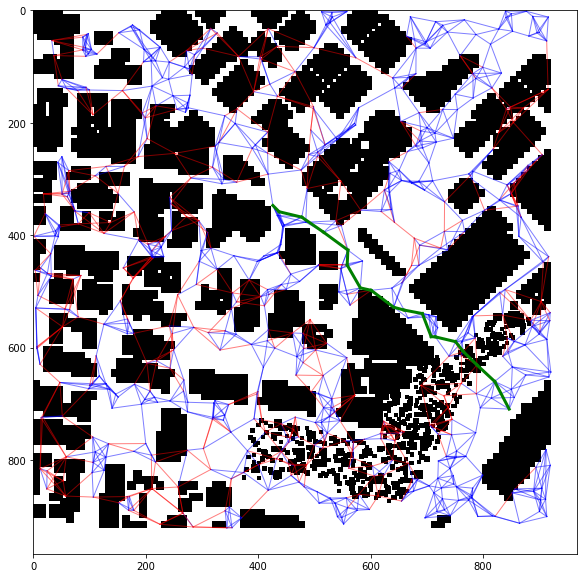

In [12]:
plt.figure(figsize=(10,10))

plt.imshow(grid, cmap='gray_r')

for (n1, n2) in graph.edges:
    
    color = 'blue' if (n1, n2) in pruned_graph.edges else 'red'
    plt.plot([n1[1]-offset_y, n2[1]-offset_y],
             [n1[0]-offset_x, n2[0]-offset_x],
             color,
             linewidth=1,
             alpha=0.5)
    
for i in range(0, len(path)-1):
    plt.plot(
        [path[i+1][1]-offset_y, path[i][1]-offset_y],
        [path[i+1][0]-offset_x, path[i][0]-offset_x],
        'green',
        linewidth=3,
        alpha=1
    )